In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
print ("pandas version:  {}".format(pd.__version__))
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import catboost
from catboost import CatBoostRegressor, Pool

print("Catboost version:  {}".format(catboost.__version__))

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

pandas version:  2.0.3
Catboost version:  1.2.2
/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv
/kaggle/input/storesalestfs-featureenigneering/__results__.html
/kaggle/input/storesalestfs-featureenigneering/__notebook__.ipynb
/kaggle/input/storesalestfs-featureenigneering/__output__.json
/kaggle/input/storesalestfs-featureenigneering/train_features.csv
/kaggle/input/storesalestfs-featureenigneering/test_features.csv
/kaggle/input/storesalestfs-featureenigneering/custom.css


This notebook follows the structure of the LightGBM notbook for this competition.

In [2]:
# read the output file of the prepare data notebook here
train = pd.read_csv('/kaggle/input/storesalestfs-featureenigneering/train_features.csv')
test = pd.read_csv('/kaggle/input/storesalestfs-featureenigneering/test_features.csv')
# and sample submission
sample_submission = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv')

In [3]:
# append train and test temporarily
train = pd.concat( [train,test])

In [4]:
train.dtypes

id                     int64
date                  object
store_nbr              int64
family                object
sales                float64
onpromotion            int64
year                   int64
month                  int64
day                    int64
dayofweek              int64
dayofyear              int64
weekofyear             int64
is_weekend              bool
weekIdContinous        int64
sales_lag2w          float64
sales_lag4w          float64
sales_lag8w          float64
sales_lag1y          float64
is_payday              int64
sf_monthly_mean      float64
sf_yearly_mean       float64
s_sales_median       float64
s_sales_mean         float64
s_sales_max          float64
s_sales_std          float64
city                  object
state                 object
type                  object
cluster                int64
transactions_mean    float64
transactions_std     float64
st_ratio             float64
c_sales_median       float64
c_sales_mean         float64
c_sales_max   

In [5]:
categorical_columns = ['store_nbr', 'cluster' , 'type', 'city', 'state' , 'family']
# convert categorical columns to dtype string
for feature in categorical_columns:
    train[feature] = train[feature].astype('str')
train.dtypes

id                     int64
date                  object
store_nbr             object
family                object
sales                float64
onpromotion            int64
year                   int64
month                  int64
day                    int64
dayofweek              int64
dayofyear              int64
weekofyear             int64
is_weekend              bool
weekIdContinous        int64
sales_lag2w          float64
sales_lag4w          float64
sales_lag8w          float64
sales_lag1y          float64
is_payday              int64
sf_monthly_mean      float64
sf_yearly_mean       float64
s_sales_median       float64
s_sales_mean         float64
s_sales_max          float64
s_sales_std          float64
city                  object
state                 object
type                  object
cluster               object
transactions_mean    float64
transactions_std     float64
st_ratio             float64
c_sales_median       float64
c_sales_mean         float64
c_sales_max   

In [6]:
# split train and test again
test = train.loc[train.id >= 3000888]
test.shape

(28512, 45)

In [7]:
train = train.loc[train.id < 3000888]
train.shape

(2361414, 45)

# Model: CatBoost

In [8]:
columns_to_drop = ['sales','id','date','is_national_hol','is_local_hol']

In [9]:
# create validation set based on time, I use 2 weeks because the test set is 2 weeks
#train.date.max()
X_train = train.loc[train.date < '2017-08-01']
X_train.tail()
y_train = X_train.sales
X_train = X_train.drop(columns_to_drop, axis = 1)
X_val = train.loc[train.date >= '2017-08-01']
y_val = X_val.sales
X_val = X_val.drop(columns_to_drop, axis = 1)

In [10]:
X_train.head()

,store_nbr,family,onpromotion,year,month,day,dayofweek,dayofyear,weekofyear,is_weekend,...,c_sales_mean,c_sales_max,c_sales_std,is_onpromotion,op_sales_median,op_sales_mean,op_sales_min,op_sales_max,dcoilwtico,is_holiday
0,1,AUTOMOTIVE,0,2014,1,1,2,1,1,False,...,6.491400,255.0,6.250549,0,3.0,3.542113,0.0,19.0,98.17,True
1,1,BABY CARE,0,2014,1,1,2,1,1,False,...,0.141260,116.0,0.766963,0,0.0,0.000000,0.0,0.0,98.17,True
2,1,BEAUTY,0,2014,1,1,2,1,1,False,...,4.076740,136.0,5.110346,0,2.0,2.263397,0.0,11.0,98.17,True
3,1,BEVERAGES,0,2014,1,1,2,1,1,False,...,2738.754588,25413.0,2431.441640,0,1093.0,1266.943522,0.0,3366.0,98.17,True
4,1,BOOKS,0,2014,1,1,2,1,1,False,...,0.090614,51.0,0.618165,0,0.0,0.159848,0.0,8.0,98.17,True


In [11]:
train_pool = Pool(X_train, label=np.log1p(y_train), cat_features=categorical_columns)
val_pool = Pool(X_val, label=np.log1p(y_val), cat_features=categorical_columns)

In [12]:
# Specify CatBoost parameters for regression NOT YET RUN WITH THESE PARAMS
params = {
    'iterations': 200,
    'loss_function': 'RMSE',  # Loss function for regression
    'eval_metric': 'RMSE',  # Evaluation metric for regression
    'learning_rate': 0.29844759163525564, 
    'depth': 15, 
    'subsample': 0.44116710254766295, 
    'colsample_bylevel': 0.8200575737708942, 
    'min_data_in_leaf': 38
}

In [13]:
model = CatBoostRegressor(**params)
model.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True,  # Use the best model based on the evaluation metric
    early_stopping_rounds = 20,
    verbose=20,  # Print metrics every 100 iterations
    
)

0:	learn: 1.9203152	test: 1.8404454	best: 1.8404454 (0)	total: 8.45s	remaining: 28m 1s
20:	learn: 0.3964602	test: 0.3868944	best: 0.3868944 (20)	total: 2m 30s	remaining: 21m 24s
40:	learn: 0.3736203	test: 0.3770447	best: 0.3770447 (40)	total: 4m 52s	remaining: 18m 52s
60:	learn: 0.3627786	test: 0.3731297	best: 0.3731297 (60)	total: 7m 10s	remaining: 16m 20s
80:	learn: 0.3537175	test: 0.3722934	best: 0.3713876 (79)	total: 9m 33s	remaining: 14m 3s
100:	learn: 0.3466543	test: 0.3700628	best: 0.3700628 (100)	total: 11m 51s	remaining: 11m 37s
120:	learn: 0.3417461	test: 0.3686607	best: 0.3685498 (119)	total: 14m 10s	remaining: 9m 15s
140:	learn: 0.3356872	test: 0.3680488	best: 0.3680488 (140)	total: 16m 30s	remaining: 6m 54s
160:	learn: 0.3313027	test: 0.3684355	best: 0.3675911 (155)	total: 18m 45s	remaining: 4m 32s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3675910898
bestIteration = 155

Shrink model to first 156 iterations.


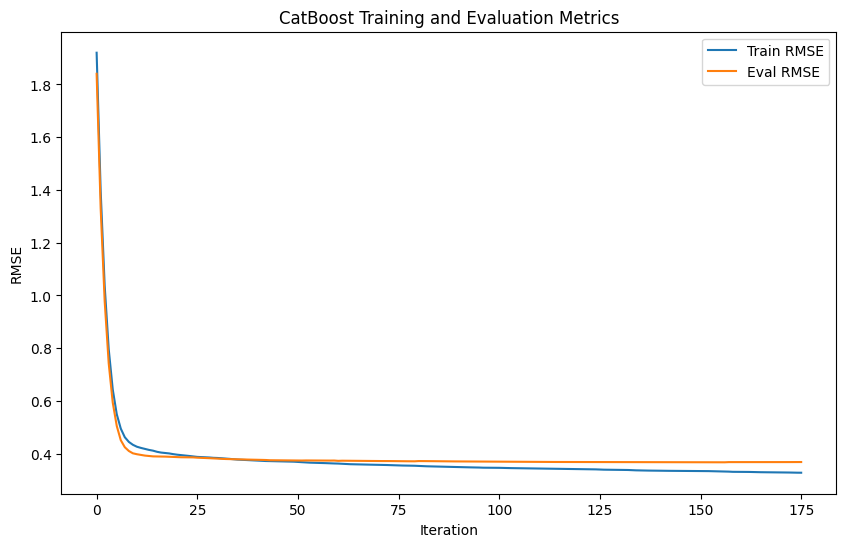

In [14]:
# Access the training and evaluation metrics
train_metric = model.evals_result_['learn']['RMSE']
eval_metric = model.evals_result_['validation']['RMSE']

# Plot the training and validation metrics over iterations
plt.figure(figsize=(10, 6))
plt.plot(train_metric, label='Train RMSE')
plt.plot(eval_metric, label='Eval RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('CatBoost Training and Evaluation Metrics')
plt.legend()
plt.show()

In [15]:
feature_importance = model.get_feature_importance(type='FeatureImportance')
feature_names = X_train.columns 
# Create a dictionary mapping feature names to their importances
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Sort the features by importance
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=False)

for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")


store_nbr: 0.003574688159540087
is_payday: 0.13864950974862092
state: 0.16918477649697294
year: 0.18733166988045585
s_sales_max: 0.2583299205625952
op_sales_max: 0.26778180352184805
op_sales_min: 0.2748103364486512
sf_yearly_mean: 0.28024410938242666
month: 0.34453467460421705
city: 0.4035278951159153
family: 0.4346131359598204
type: 0.4559901052604208
s_sales_mean: 0.5412383071655175
transactions_mean: 0.5451483406493678
s_sales_median: 0.5803237570525871
onpromotion: 0.6669624185929334
cluster: 0.6736366298857454
is_holiday: 0.6870302656025027
transactions_std: 0.760058545346284
st_ratio: 0.8481873805436406
c_sales_median: 0.8606982043541281
s_sales_std: 1.0116580200487013
is_onpromotion: 1.1406012924686382
c_sales_std: 1.174238543339214
weekofyear: 1.26893884979679
c_sales_mean: 1.526928042166523
op_sales_mean: 1.565445347026097
dcoilwtico: 1.6731565291542725
is_weekend: 1.8632145343962685
c_sales_max: 1.8665985769736813
weekIdContinous: 2.0217823994338575
sales_lag1y: 2.25719874202

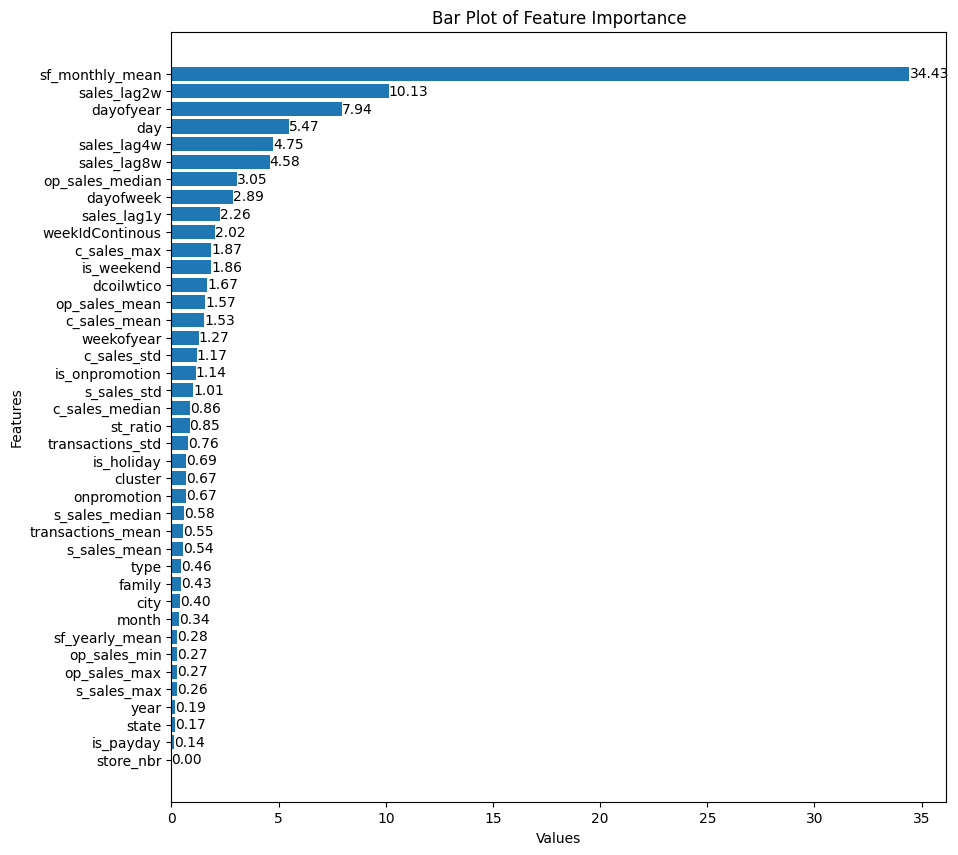

In [16]:
sorted_feature_importance
# Extract data for plotting
labels, values = zip(*sorted_feature_importance)
# Create a bar plot
plt.figure(figsize=(10, 10))
bars = plt.barh(labels, values)
plt.xlabel('Values')
plt.ylabel('Features')
plt.title('Bar Plot of Feature Importance')
# Add labels to the bars
for bar, value in zip(bars, values):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{value:.2f}', ha='left', va='center')

plt.show()

Retrain on whole dataset

In [17]:
traint_pool = Pool(train.drop(columns_to_drop, axis = 1), label = np.log1p(train.sales), cat_features=categorical_columns)
test_pool = Pool(test.drop(columns_to_drop, axis = 1), cat_features=categorical_columns)

In [18]:
model.fit(traint_pool,verbose=50)

0:	learn: 1.9147551	total: 8.55s	remaining: 28m 21s
50:	learn: 0.3678452	total: 6m 27s	remaining: 18m 52s
100:	learn: 0.3471762	total: 12m 51s	remaining: 12m 35s
150:	learn: 0.3323773	total: 19m 21s	remaining: 6m 16s
199:	learn: 0.3234447	total: 25m 42s	remaining: 0us


In [19]:
preds = np.expm1(model.predict(test_pool)) # transform predictions back immediatelly

In [20]:
preds.min()

-0.20818836785062805

In [21]:
preds.max()

13395.903912490394

In [22]:
preds = preds.clip(0,20000)

# Postprocessing

In [23]:
test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')

submission_pre = pd.DataFrame(data={"id" : sample_submission.id,
                                   "preds" : preds})

submission_pre = pd.merge(test,submission_pre, on='id',how='left')

# get info about which stores have 0 sales for which categories out of train
store_info=train[['store_nbr','family','sales']].groupby(['store_nbr','family']).sum().reset_index()
store_info = store_info.loc[store_info.sales == 0] #reduce to those without sales

categories_not_sold_in_all_stores = store_info.family.unique()

# set all predictions to 0 for the categories that are not sold in certain stores
for cat in categories_not_sold_in_all_stores:
    category = cat
    stores_that_dont_sell_category = list(store_info.loc[(store_info.family == category)].store_nbr)
    submission_pre.loc[submission_pre.store_nbr.isin(stores_that_dont_sell_category) & (submission_pre.family==category),['preds']] = 0
    
submission_pre.head()

,id,date,store_nbr,family,onpromotion,preds
0,3000888,2017-08-16,1,AUTOMOTIVE,0,5.159646
1,3000889,2017-08-16,1,BABY CARE,0,0.000000
2,3000890,2017-08-16,1,BEAUTY,2,6.214798
3,3000891,2017-08-16,1,BEVERAGES,20,2589.604449
4,3000892,2017-08-16,1,BOOKS,0,0.022087


# Submission

In [24]:
# generate submission file 
submission = submission_pre[['id','preds']]
submission = submission.rename(columns={'preds':'sales'})

submission.to_csv('submission.csv', index=False)
submission.head()

,id,sales
0,3000888,5.159646
1,3000889,0.000000
2,3000890,6.214798
3,3000891,2589.604449
4,3000892,0.022087
